In [1]:
import numpy as np
import pytest
from qtm.models.qkernel import QKernel

In [2]:
k = QKernel(
        num_qubits=3,
        encoding="angle",
        ansatz="embedding_pattern",
        kernel_layers=1,
        embedding_rotation="ry",
        scaling=1.0,
        reupload=False,
        ansatz_entanglement="linear",
        shots=None,  # statevector mode
    )

In [3]:
weights = np.random.uniform(
    0, 2*np.pi,
    size=(k._kernel_layers, 2, k._num_qubits)
)

x1 = np.array([0.1, 0.5, 0.9])
x2 = np.array([0.2, 0.4, 0.8])

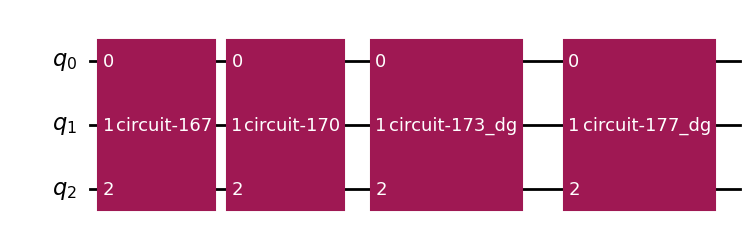

In [4]:
k.draw_kernel_circuit(x1, x2, weights)